In [2]:
# This notebook is obsolete now, 
# was only used for experiments,
# refer to stylegan_blending.py for the final integrated code

In [2]:
import os
import re
from typing import List, Optional

import click
import dnnlib
import numpy as np
import PIL.Image
import torch

import legacy

import copy

In [3]:
network_pkl1="pretrained/ffhq-res512-mirror-stylegan2-noaug.pkl"
network_pkl2="pretrained/afhqcat.pkl"

In [4]:

print(f"Loading networks from {network_pkl1} and {network_pkl2} ...")
device = torch.device("cuda")
with dnnlib.util.open_url(network_pkl1) as f:
    G1 = legacy.load_network_pkl(f)["G_ema"].to(device)  # type: ignore
with dnnlib.util.open_url(network_pkl2) as f:
    G2 = legacy.load_network_pkl(f)["G_ema"].to(device)  # type: ignore


Loading networks from pretrained/ffhq-res512-mirror-stylegan2-noaug.pkl and pretrained/afhqcat.pkl ...


In [5]:
# get_model_names(model, max_dim=1024):
model = G1
max_dim=512
val = 1 + int(np.log2(max_dim / 4))  # 9 for 1024, 8 for 512
resolutions = [4 * 2 ** x for x in range(val)]

In [6]:
names = [x[0] for x in list(model.named_parameters())]
# model.named_parameters()

In [7]:
# layer names in pytorch are like b4.name
level_names = [["conv0", "const"],
                    ["conv1", "torgb"]]

In [8]:
names[:5],"...",names[-5:]

(['synthesis.b4.const',
  'synthesis.b4.conv1.weight',
  'synthesis.b4.conv1.noise_strength',
  'synthesis.b4.conv1.bias',
  'synthesis.b4.conv1.affine.weight'],
 '...',
 ['mapping.fc5.bias',
  'mapping.fc6.weight',
  'mapping.fc6.bias',
  'mapping.fc7.weight',
  'mapping.fc7.bias'])

In [9]:
# method for accessing params - 
#TODO: check if this approach is ok to edit model params
# model.state_dict()['synthesis.b512.torgb.affine.bias']

In [10]:
resolutions

[4, 8, 16, 32, 64, 128, 256, 512]

In [11]:
position=0
conv_names=[]
for res in resolutions:
    rootname = f"synthesis.b{res}."
    for level, level_suffixes in enumerate(level_names):
        for suffix in level_suffixes:
            searchname = rootname+suffix
            matches = [x for x in names if x.startswith(searchname)]
            info_tuples = [(name, f"b{res}",level,position) for name in matches]
            conv_names.extend(info_tuples)
        position+=1



In [12]:
conv_names[:5],"...",conv_names[-5:]

([('synthesis.b4.const', 'b4', 0, 0),
  ('synthesis.b4.conv1.weight', 'b4', 1, 1),
  ('synthesis.b4.conv1.noise_strength', 'b4', 1, 1),
  ('synthesis.b4.conv1.bias', 'b4', 1, 1),
  ('synthesis.b4.conv1.affine.weight', 'b4', 1, 1)],
 '...',
 [('synthesis.b512.conv1.affine.bias', 'b512', 1, 15),
  ('synthesis.b512.torgb.weight', 'b512', 1, 15),
  ('synthesis.b512.torgb.bias', 'b512', 1, 15),
  ('synthesis.b512.torgb.affine.weight', 'b512', 1, 15),
  ('synthesis.b512.torgb.affine.bias', 'b512', 1, 15)])

In [13]:
def get_conv_names(model,max_dim):
    val = 1 + int(np.log2(max_dim / 4))  # 9 for 1024, 8 for 512
    resolutions = [4 * 2 ** x for x in range(val)]
    names = [x[0] for x in list(model.named_parameters())]
    level_names = [["conv0", "const"],["conv1", "torgb"]]
    position=0
    conv_names=[]
    for res in resolutions:
        rootname = f"synthesis.b{res}."
        for level, level_suffixes in enumerate(level_names):
            for suffix in level_suffixes:
                searchname = rootname+suffix
                matches = [x for x in names if x.startswith(searchname)]
                info_tuples = [(name, f"b{res}",level,position) for name in matches]
                conv_names.extend(info_tuples)
            position+=1
    return conv_names

In [14]:
get_conv_names(G1,512)

[('synthesis.b4.const', 'b4', 0, 0),
 ('synthesis.b4.conv1.weight', 'b4', 1, 1),
 ('synthesis.b4.conv1.noise_strength', 'b4', 1, 1),
 ('synthesis.b4.conv1.bias', 'b4', 1, 1),
 ('synthesis.b4.conv1.affine.weight', 'b4', 1, 1),
 ('synthesis.b4.conv1.affine.bias', 'b4', 1, 1),
 ('synthesis.b4.torgb.weight', 'b4', 1, 1),
 ('synthesis.b4.torgb.bias', 'b4', 1, 1),
 ('synthesis.b4.torgb.affine.weight', 'b4', 1, 1),
 ('synthesis.b4.torgb.affine.bias', 'b4', 1, 1),
 ('synthesis.b8.conv0.weight', 'b8', 0, 2),
 ('synthesis.b8.conv0.noise_strength', 'b8', 0, 2),
 ('synthesis.b8.conv0.bias', 'b8', 0, 2),
 ('synthesis.b8.conv0.affine.weight', 'b8', 0, 2),
 ('synthesis.b8.conv0.affine.bias', 'b8', 0, 2),
 ('synthesis.b8.conv1.weight', 'b8', 1, 3),
 ('synthesis.b8.conv1.noise_strength', 'b8', 1, 3),
 ('synthesis.b8.conv1.bias', 'b8', 1, 3),
 ('synthesis.b8.conv1.affine.weight', 'b8', 1, 3),
 ('synthesis.b8.conv1.affine.bias', 'b8', 1, 3),
 ('synthesis.b8.torgb.weight', 'b8', 1, 3),
 ('synthesis.b8.tor

# -----------------------------

# Blending playground

In [15]:
# G1, G2, max_dim
model1_names = get_conv_names(G1,max_dim)
model2_names = get_conv_names(G2,max_dim)

In [16]:
assert all((x == y for x, y in zip(model1_names, model2_names)))


In [17]:
output_model = copy.deepcopy(G1)

In [18]:
# method for accessing params - 
#TODO: check if this approach is ok to edit model params
# model.state_dict()['synthesis.b512.torgb.affine.bias']

In [88]:
resolution = "b128"
level = 0
short_names = [(x[1:3]) for x in model1_names]
full_names = [(x[0]) for x in model1_names]
mid_point_idx = short_names.index((resolution, level))
mid_point_pos = model1_names[mid_point_idx][3]

In [89]:
ys = []
verbose=True
blend_width = None # None = hard switch, float = smooth switch (logistic) with given width
for name, resolution, level, position in model1_names:
    x = position - mid_point_pos
    if blend_width:
        exponent = -x/blend_width
        y = 1 / (1 + math.exp(exponent))
    else:
        y = 1 if x > 1 else 0
    ys.append(y)
    if verbose:
        print(f"Blending {name} by {y}")
    

Blending synthesis.b4.const by 0
Blending synthesis.b4.conv1.weight by 0
Blending synthesis.b4.conv1.noise_strength by 0
Blending synthesis.b4.conv1.bias by 0
Blending synthesis.b4.conv1.affine.weight by 0
Blending synthesis.b4.conv1.affine.bias by 0
Blending synthesis.b4.torgb.weight by 0
Blending synthesis.b4.torgb.bias by 0
Blending synthesis.b4.torgb.affine.weight by 0
Blending synthesis.b4.torgb.affine.bias by 0
Blending synthesis.b8.conv0.weight by 0
Blending synthesis.b8.conv0.noise_strength by 0
Blending synthesis.b8.conv0.bias by 0
Blending synthesis.b8.conv0.affine.weight by 0
Blending synthesis.b8.conv0.affine.bias by 0
Blending synthesis.b8.conv1.weight by 0
Blending synthesis.b8.conv1.noise_strength by 0
Blending synthesis.b8.conv1.bias by 0
Blending synthesis.b8.conv1.affine.weight by 0
Blending synthesis.b8.conv1.affine.bias by 0
Blending synthesis.b8.torgb.weight by 0
Blending synthesis.b8.torgb.bias by 0
Blending synthesis.b8.torgb.affine.weight by 0
Blending synthesis

In [90]:
new_model_state_dict = output_model.state_dict()
for name, y in zip(full_names,ys):
    new_model_state_dict[name] = G2.state_dict()[name]*y+G2.state_dict()[name]*(1-y)
# .state_dict()['synthesis.b512.torgb.affine.bias']

In [91]:
output_model.load_state_dict(new_model_state_dict)

<All keys matched successfully>

In [92]:
# output_model
seed=277
device='cuda'

In [93]:
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G1.z_dim)).to(device)

In [94]:
label = torch.zeros([1, G1.c_dim], device=device)
class_idx=None
if G1.c_dim != 0:
    if class_idx is None:
        ctx.fail('Must specify class label with --class when using a conditional network')
    label[:, class_idx] = 1
else:
    if class_idx is not None:
        print ('warn: --class=lbl ignored when running on an unconditional network')


In [95]:
g1_img = G1(z, label, truncation_psi=1, noise_mode='const')
g1_img = (g1_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
g1_imgfile = PIL.Image.fromarray(g1_img[0].cpu().numpy(), 'RGB')
g1_imgfile.save(f'G1seed{seed:04d}.png')
g2_img = G2(z, label, truncation_psi=1, noise_mode='const')
g2_img = (g2_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
g2_imgfile = PIL.Image.fromarray(g2_img[0].cpu().numpy(), 'RGB')
g2_imgfile.save(f'G2seed{seed:04d}.png')

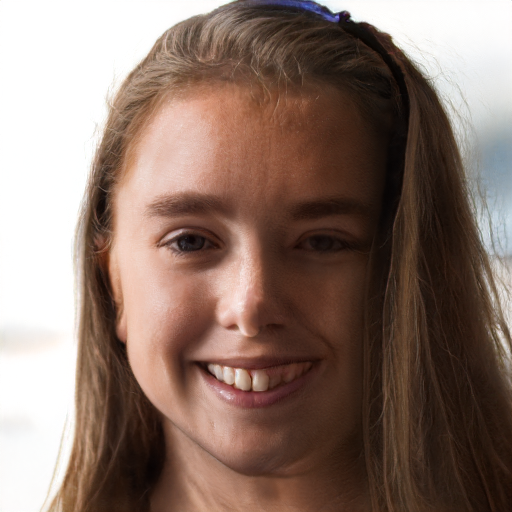

In [96]:
g1_imgfile

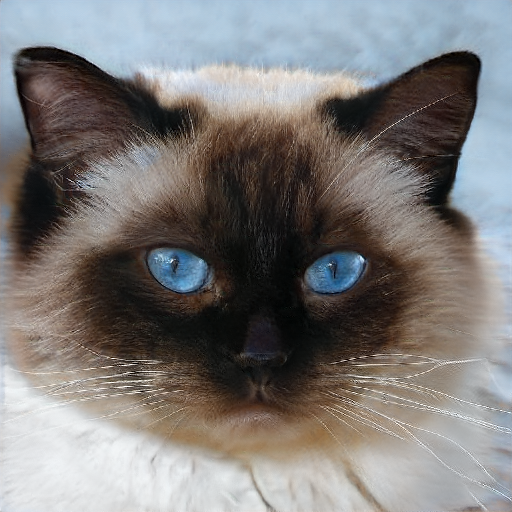

In [97]:
g2_imgfile

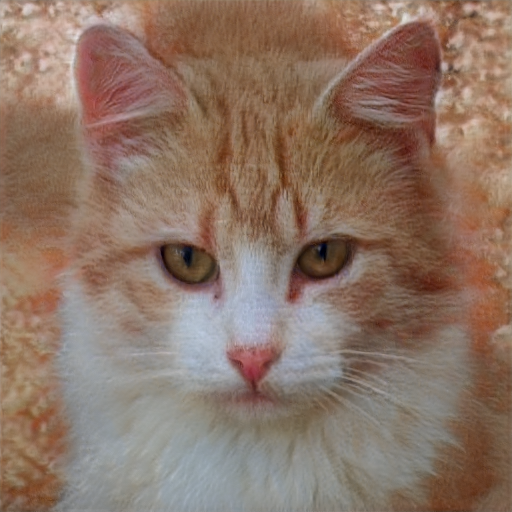

In [102]:
blended_img = output_model(z, 0, truncation_psi=0.7, noise_mode='const')
blended_img = (blended_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
blended_imgfile = PIL.Image.fromarray(blended_img[0].cpu().numpy(), 'RGB')
blended_imgfile.save(f'Blended_seed{seed:04d}.png')
blended_imgfile